# DP1 Inference with DeepDISC

Before perusing this notebook, take a look at the `prep_dp1_for_dd.ipynb` to understand how the DP1 data is being formatted and saved to prepare it for inference with the DeepDISC models.

This notebook explains the setup, configuration, model loading, inference loop, and result saving. It's essentially `dp1_infernce.py` with more detailed comments and notes. We will be running a trained **Cascade Mask R-CNN (Swin-B backbone)** model on LSST Data Preview 1 (DP1) cutouts to produce object detection and instance segmentation predictions.
**Equivalent CLI command:**
```bash
cd ~/dp1/
python dp1_inference.py \
    --cfgfile /u/yse2/deepdisc/configs/solo/swin_lsst_job.py \
    --model_path /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/lsst5_30k_4h200_bs192_ep50.pth \
    --test_data_fn ~/dp1/test.json \
    --output_dir ~/dp1/preds \
    --topk_per_img 2000 \
    --num_gpus 2 \
    --score_thresholds 0.25 \
    --nms_thresholds 0.5
```

---

# Imports & Path Setup

We import:
- **Standard libraries** for file I/O, timing, and argument handling.
- **PyTorch** for tensor ops and GPU management.
- **Astropy** for World Coordinate System (WCS) transformations (pixel coords -> RA/Dec).
- **Detectron2** for config loading, model instantiation, checkpointing, and data loading.
- **pycocotools** for encoding predicted masks into Run-Length Encoding (RLE) format.
- **DeepDISC** custom modules:
  - `FileNameWCSMapper` — our custom data mapper that loads cutout images, applies augmentations, and returns `file_name` and `wcs` fields (unlike the base `DataMapper`)
  - `register_data_set` — registers test data with Detectron2's `DatasetCatalog` so the data loader knows how to find and iterate over images.
  - `return_test_loader` — builds a Detectron2 test DataLoader with configurable batch size and `filter_empty=False`.

In [55]:
import itertools
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os
import sys
import json
import time
import gc
import numpy as np
import pandas as pd
import torch
import pycocotools.mask as mask_util
import matplotlib.pyplot as plt

# Astropy for WCS
# import units degree from astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import AsinhStretch, ImageNormalize, make_lupton_rgb
def asinh_norm(data, a=0.1):
    finite_data = data[np.isfinite(data)] # ensure no NaN or inf vals
    if len(finite_data) == 0:
        return ImageNormalize(vmin=0, vmax=1, stretch=AsinhStretch(a=a))
    # percentile-based limits
    vmin, vmax = np.percentile(finite_data, [1, 99])
    return ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(a=a))

# Insert the custom configs directory so we can import our custom mappers
# This path points to deepdisc/configs/ which contains custom/mappers.py
sys.path.insert(0, '/u/yse2/deepdisc/configs')

# Detectron2
from detectron2.config import LazyConfig, instantiate
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from deepdisc.astrodet.visualizer import Visualizer, ColorMode

# DeepDISC
from custom.mappers import FileNameWCSMapper
from deepdisc.data_format.register_data import register_data_set
from deepdisc.model.loaders import return_test_loader


print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

PyTorch version: 2.9.1+cu128
CUDA available: False


# Define Parameters

In the script, these come from `argparse` command-line arguments. Here we set them directly.

| Parameter | Description |
|---|---|
| `cfg_file` | Path to the DeepDISC/Detectron2 LazyConfig (`.py`) that defines the model architecture, backbone, and dataloader settings. |
| `model_path` | Path to the trained model checkpoint (`.pth` file). |
| `test_data_fn` | Path to the COCO-formatted JSON describing the test cutouts (created by `prep_dp1_for_dd.py`). |
| `output_dir` | Directory to save prediction JSON files. |
| `topk_per_img` | Maximum number of detections to keep per image (after NMS). |
| `score_thresholds` | Confidence score thresholds — only keep detections above this. |
| `nms_thresholds` | Non-Maximum Suppression IoU thresholds — when two boxes overlap more than this, the lower-scoring one is removed. |

In [ ]:
# ---- Parameters (equivalent to argparse in the script) ----
cfg_file = "/u/yse2/deepdisc/configs/solo/swin_lsst_job.py" # /projects/bfyl/swin_lsst_job.py is the same file and you will need to put this file in your deepdisc folder
model_path = "/projects/bfyl/lsst5_30k_4h200_bs192_ep50.pth"
test_data_fn = os.path.expanduser("~/dp1/test.json")
output_dir = os.path.expanduser("~/dp1/preds")
topk_per_img = 2000
score_thresholds = [0.25]
nms_thresholds = [0.5]

# Create all (score_thresh, nms_thresh) combinations to iterate over
threshold_combos = list(itertools.product(score_thresholds, nms_thresholds))
os.makedirs(output_dir, exist_ok=True)

print(f"Config file: {cfg_file}")
print(f"Model checkpoint: {model_path}")
print(f"Test data: {test_data_fn}")
print(f"Output dir: {output_dir}")
print(f"Top-K per image: {topk_per_img}")
print(f"Threshold combinations: {threshold_combos}")

Config file: /u/yse2/deepdisc/configs/solo/swin_lsst_job.py
Model checkpoint: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/lsst5_30k_4h200_bs192_ep50.pth
Test data: /u/yse2/dp1/test.json
Output dir: /u/yse2/dp1/preds
Top-K per image: 2000
Threshold combinations: [(0.25, 0.5)]


# Load the Config

We use Detectron2's `LazyConfig.load()` to load the config from `swin_lsst_job.py`. This config file:

1. **Defines the model architecture**: Cascade Mask R-CNN with a Swin-B (ImageNet-21k pretrained) backbone, modified for 6-channel input (LSST ugrizy bands) and 2 classes (galaxy, star).
2. **Sets the backbone's `square_pad = 128`**: Since the FPN requires image dimensions divisible by 32, and the DP1 cutouts we made with `prep_dp1_for_dd.py` are 128x128, we set the square pad to 128. If you choose a different cutout size, you will need to adjust this parameter. 
3. **Specifies `pixel_mean` and `pixel_std`**: Per-channel normalization values computed from the *training* data. We **override these** below with DP1-specific values since DP1 has a different flux distribution than the simulated training data.
4. **Defines the data pipeline**: `key_mapper` returns the file path from the dataset dict, and `RomanRubinImageReader` loads `.npy` cutouts.

Key overrides for inference:
- `cfg.DATASETS.TEST = "test"` — name we'll register our DP1 dataset under.
- `cfg.dataloader.augs = None` — **no augmentations** for test, since we want predictions on unmodified images.
- `cfg.dataloader.test.mapper = FileNameWCSMapper` — a custom mapper that includes `file_name` and `wcs` in each sample.

In [4]:
# Load the LazyConfig
cfg = LazyConfig.load(cfg_file)

# Merge any MISC keys into the top-level config
# (this is a pattern used in DeepDISC configs to keep yaml-style and lazy-style configs compatible)
for key in cfg.get("MISC", dict()).keys():
    cfg[key] = cfg.MISC[key]

# Override for test/inference
cfg.DATASETS.TEST = "test"
cfg.dataloader.augs = None  # no augmentations for inference
cfg.dataloader.test.mapper = FileNameWCSMapper  # custom mapper that returns file_name and wcs
cfg.train.init_checkpoint = model_path
cfg.model.backbone.square_pad = 128

print(f"Model backbone: Swin-B")
print(f"Input channels: {cfg.model.backbone.bottom_up.in_chans}")
print(f"Square pad: {cfg.model.backbone.square_pad}")
print(f"Number of classes: {cfg.model.roi_heads.num_classes}")
print(f"Classes: {cfg.metadata.classes}")

Model backbone: Swin-B
Input channels: 6
Square pad: 128
Number of classes: 2
Classes: ['galaxy', 'star']


# Register the Test Dataset

Detectron2 uses a **dataset registration** system: you associate a string name (e.g., `"test"`) with a function that returns a list of COCO-formatted dicts. This lets the data loader access images by name.

`register_data_set()` from DeepDISC:
1. Reads `test.json` (created by `prep_dp1_for_dd.py`) which contains metadata for each cutout: `file_name`, `image_id`, `height`, `width`, `wcs`, `annotations` (empty list for DP1).
2. Registers it with `DatasetCatalog.register("test", lambda: load_json(test_data_fn))`.
3. Sets metadata like `thing_classes=["galaxy", "star"]` and custom colors.

In [5]:
# Remove any previously registered dataset with the same name (prevents errors on re-run)
try:
    DatasetCatalog.remove(cfg.DATASETS.TEST)
    MetadataCatalog.remove(cfg.DATASETS.TEST)
except:
    pass

custom_colors = [
    (0, 255, 0),    # green for galaxies
    (0, 0, 255),    # blue for stars
]

astrotest_metadata = register_data_set(
    cfg.DATASETS.TEST, test_data_fn,
    thing_classes=cfg.metadata.classes,
    thing_colors=custom_colors
)

# Quick check: how many images are in the test set?
test_dicts = DatasetCatalog.get("test")
print(f"Registered {len(test_dicts)} test images")
print(f"Sample entry keys: {list(test_dicts[0].keys())}")
print(f"Sample file_name: {test_dicts[0]['file_name']}")
print(f"Annotations per image (should be empty for DP1): {len(test_dicts[0]['annotations'])}")

Registered 3174 test images
Sample entry keys: ['file_name', 'image_id', 'height', 'width', 'patch', 'tract', 'cutout_id', 'overlaps_with_hst', 'wcs', 'annotations']
Sample file_name: p24/full_c0.npy
Annotations per image (should be empty for DP1): 0


# Build the Data Mapper & Test DataLoader

The **data mapper** is the function that transforms each raw dataset dict into the format the model expects. Our `FileNameWCSMapper` does:

1. **Deep-copies** the dataset dict to avoid mutating the original.
2. Calls `key_mapper(dataset_dict)` to get the file path.
3. Calls `ImageReader(path)` to load the `.npy` cutout → returns `(H, W, 6)` float32 array.
4. Wraps in `T.AugInput` and applies augmentations (none for inference since `cfg.dataloader.augs = None`).
5. Converts to `(6, H, W)` torch tensor.
6. Transforms annotations (empty for DP1) and converts to `Instances` object.
7. Returns dict with `image`, `image_shaped`, `height`, `width`, `image_id`, `instances`, `file_name`, `wcs`.

The **test DataLoader** (`return_test_loader`) then:
1. Calls `get_detection_dataset_dicts("test", filter_empty=False)` — crucially `filter_empty=False` since DP1 images have no annotations.
2. Wraps in `build_detection_test_loader` with the mapper, batch size, and num workers.

In [6]:
# Configure batch size for single-GPU notebook use
# (In the script, this is calculated as 32 * 3 * num_gpus for multi-GPU)
cfg.dataloader.test.total_batch_size = 8  # smaller batch size for notebook
cfg.dataloader.test.num_workers = 4

# Instantiate the mapper:
# DP1Mapper(image_reader, key_mapper, augmentations).map_data
# .map_data is the callable that the DataLoader will call on each dataset dict
mapper = cfg.dataloader.test.mapper(
    cfg.dataloader.imagereader,   # RomanRubinImageReader: loads .npy
    cfg.dataloader.key_mapper,    # roman_key_mapper: returns dataset_dict["file_name"]
    cfg.dataloader.augs           # None for inference
).map_data

# Build the test loader
test_loader = return_test_loader(cfg, mapper)
print(f"Test DataLoader created with {len(test_loader)} batches")
print(f"Batch size: {cfg.dataloader.test.total_batch_size}")

[02/17 12:04:12 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   galaxy   | 0            |    star    | 0            |
|            |              |            |              |
|   total    | 0            |            |              |
[02/17 12:04:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/17 12:04:12 d2.data.common]: Serializing 3174 elements to byte tensors and concatenating them all ...
[02/17 12:04:12 d2.data.common]: Serialized dataset takes 9.22 MiB
Test DataLoader created with 397 batches
Batch size: 8


# Override Pixel Mean/Std for DP1

The model normalizes input images in its forward pass as: `(image - pixel_mean) / pixel_std`.

The config file has pixel mean/std computed from the **simulated training data** (DC2). DP1 is **real observational data** with a very different flux distribution, so we override with values computed from the DP1 cutouts themselves (using `dp1_pixel_mean_std.py`).

These values are per-channel (ugrizy bands):

In [7]:
# DP1-specific pixel normalization values
# Computed from the DP1 cutouts across all 6 ugrizy bands
cfg.model.pixel_mean = [
    2.673048496246338,    # u-band
    4.275834560394287,    # g-band
    6.809510707855225,    # r-band
    6.692336082458496,    # i-band
    8.969269752502441,    # z-band
    12.77933406829834,    # y-band
]
cfg.model.pixel_std = [
    32.0528450012207,     # u-band
    42.218772888183594,   # g-band
    70.36144256591797,    # r-band
    66.37097930908203,    # i-band
    89.78242492675781,    # z-band
    145.3740997314453,    # y-band
]

print("DP1 pixel normalization values set.")
print(f"  pixel_mean: {[f'{v:.2f}' for v in cfg.model.pixel_mean]}")
print(f"  pixel_std:  {[f'{v:.2f}' for v in cfg.model.pixel_std]}")

DP1 pixel normalization values set.
  pixel_mean: ['2.67', '4.28', '6.81', '6.69', '8.97', '12.78']
  pixel_std:  ['32.05', '42.22', '70.36', '66.37', '89.78', '145.37']


# Instantiate & Load the Model

1. `instantiate(cfg.model)` builds the full Cascade Mask R-CNN from the config.
2. We move it to GPU if available.
3. `DetectionCheckpointer` loads the trained weights from the `.pth` checkpoint.
4. `model.eval()` sets the model to evaluation mode (disables dropout, uses running stats for batch norm).

**Note:** In the multi-GPU script, the model is wrapped in `DistributedDataParallel` (DDP) via `create_ddp_model()`. In this notebook we run on a single GPU, so we skip DDP wrapping.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Instantiate the model from config
model = instantiate(cfg.model)
model.to(device)

# Load trained weights
print(f"Loading checkpoint from: {model_path}")
checkpointer = DetectionCheckpointer(model)
checkpointer.load(model_path)

# Set to evaluation mode
model.eval()
print("Model loaded and set to eval mode.")

Using device: cpu


/projects/bdsp/miniconda3/envs/ddbtknv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading checkpoint from: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/lsst5_30k_4h200_bs192_ep50.pth
[02/17 12:06:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/lsst5_30k_4h200_bs192_ep50.pth ...
Model loaded and set to eval mode.


# Set Detection Thresholds

The Cascade Mask R-CNN has multiple cascade stages, each with its own `box_predictor`. We set three parameters on each:

- **`test_score_thresh`**: Minimum confidence score to keep a detection. Detections below this are discarded.
- **`test_nms_thresh`**: Non-Maximum Suppression (NMS) IoU threshold. NMS removes duplicate detections for the same object:
  1. Pick the highest-scoring box.
  2. Compute IoU with all other boxes.
  3. Remove boxes with IoU > `nms_thresh` (they're likely duplicates).
  4. Repeat for the next highest-scoring remaining box.
- **`test_topk_per_image`**: Maximum number of detections to keep per image after all filtering.

In [9]:
test_score_thresh = score_thresholds[0]  # 0.25
nms_thresh = nms_thresholds[0]           # 0.5

# Set thresholds on each cascade stage's box predictor
# (No .module wrapper needed since we're not using DDP in the notebook)
for box_pred in model.roi_heads.box_predictor:
    box_pred.test_topk_per_image = topk_per_img
    box_pred.test_score_thresh = test_score_thresh
    box_pred.test_nms_thresh = nms_thresh

print(f"Score threshold: {test_score_thresh}")
print(f"NMS threshold: {nms_thresh}")
print(f"Top-K per image: {topk_per_img}")

Score threshold: 0.25
NMS threshold: 0.5
Top-K per image: 2000


# Run Inference on a Single Cutout Example

Here we demonstrate running the model on a **single cutout** end-to-end: load one image, pass it through the mapper, run inference, and visualize the predictions.

This is useful for debugging and quick inspection without running the full inference pipeline.

In [66]:
# Pick a single cutout from the test set
single_entry = test_dicts[1500]
print(f"File: {single_entry['file_name']}")
print(f"Image ID: {single_entry['image_id']}")
print(f"Size: {single_entry['height']}x{single_entry['width']}")
print(f"Patch: {single_entry.get('patch', 'N/A')}")
print(f"Overlaps with HST: {single_entry['overlaps_with_hst']}")

File: p34/full_c442.npy
Image ID: 442
Size: 128x128
Patch: 34
Overlaps with HST: True


In [64]:
# Run the mapper on this single entry — same processing the DataLoader does
sample = mapper(single_entry)
print(f"Mapped sample keys: {list(sample.keys())}")
print(f"Image tensor shape: {sample['image'].shape}  (C, H, W)")
print(f"File name: {sample['file_name']}")

Mapped sample keys: ['image', 'image_shaped', 'height', 'width', 'image_id', 'instances', 'file_name', 'wcs']
Image tensor shape: torch.Size([6, 128, 128])  (C, H, W)
File name: p34/full_c442.npy


In [65]:
# Run inference on just this one image
# The model expects a list of dicts (a batch)
with torch.no_grad():
    outputs = model([sample])

instances = outputs[0]['instances'].to('cpu')
print(f"\nDetections: {len(instances)}")
print(f"  Scores: {instances.scores.numpy()}")
print(f"  Classes: {instances.pred_classes.numpy()}  (0=galaxy, 1=star)")
print(f"  Boxes (x1,y1,x2,y2): ")
for i, box in enumerate(instances.pred_boxes.tensor.numpy()):
    cls_name = cfg.metadata.classes[instances.pred_classes[i].item()]
    score = instances.scores[i].item()
    print(f"    [{cls_name}] score={score:.3f}  box={box}")


Detections: 19
  Scores: [0.99985236 0.9994775  0.99859256 0.99789613 0.99399424 0.9879223
 0.9802022  0.95947164 0.8926057  0.88701844 0.8802099  0.86991215
 0.86548316 0.76133984 0.62083733 0.40501153 0.37317568 0.33466655
 0.3032003 ]
  Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]  (0=galaxy, 1=star)
  Boxes (x1,y1,x2,y2): 
    [galaxy] score=1.000  box=[ 65.71776   14.654657 105.31549   50.29548 ]
    [galaxy] score=0.999  box=[ 15.509668  85.988556  47.597733 118.357346]
    [galaxy] score=0.999  box=[54.8958  27.07405 81.34646 53.30555]
    [galaxy] score=0.998  box=[18.549553  3.204667 39.224957 23.379326]
    [galaxy] score=0.994  box=[43.198204 54.51333  62.215797 73.87948 ]
    [galaxy] score=0.988  box=[59.741516 19.348314 80.5215   40.416916]
    [galaxy] score=0.980  box=[41.07235  14.163571 66.59556  41.333885]
    [galaxy] score=0.959  box=[ 95.41798     1.6969156 112.03289    18.091774 ]
    [galaxy] score=0.893  box=[ 98.55785   41.42917  113.28455   56.151596]
  

In [67]:
# Convert RA/Dec for the single cutout's detections
if len(instances) > 0:
    cutout_wcs = WCS(sample['wcs'])
    centers = instances.pred_boxes.get_centers().numpy()
    sky_coords = cutout_wcs.pixel_to_world(centers[:, 0], centers[:, 1])
    print("Detection sky coordinates:")
    for i in range(len(instances)):
        cls_name = cfg.metadata.classes[instances.pred_classes[i].item()]
        print(f"  {cls_name}: RA={sky_coords.ra.degree[i]:.6f}, Dec={sky_coords.dec.degree[i]:.6f}")

Detection sky coordinates:
  galaxy: RA=53.229602, Dec=-27.714839
  galaxy: RA=53.232983, Dec=-27.710964
  galaxy: RA=53.230693, Dec=-27.714410
  galaxy: RA=53.233157, Dec=-27.715901
  galaxy: RA=53.231659, Dec=-27.713075
  galaxy: RA=53.230568, Dec=-27.714982
  galaxy: RA=53.231591, Dec=-27.715100
  galaxy: RA=53.228461, Dec=-27.716095
  galaxy: RA=53.228320, Dec=-27.713934
  galaxy: RA=53.233227, Dec=-27.709804
  galaxy: RA=53.232119, Dec=-27.712525
  galaxy: RA=53.233821, Dec=-27.711646
  galaxy: RA=53.232592, Dec=-27.714951
  galaxy: RA=53.227498, Dec=-27.713631
  galaxy: RA=53.233655, Dec=-27.714379
  galaxy: RA=53.233211, Dec=-27.709918
  galaxy: RA=53.227249, Dec=-27.713318
  galaxy: RA=53.232949, Dec=-27.711337
  galaxy: RA=53.229851, Dec=-27.714889


Let's also plot the LSST Detections to compare agains the DeepDISC detections.

In [ ]:
patch_cat = pd.read_json(f"full_p{single_entry['patch']}.json", orient='records')
coords = SkyCoord(ra=patch_cat['coord_ra'].values * u.deg,
                  dec=patch_cat['coord_dec'].values * u.deg)
patch_xpix, patch_ypix = cutout_wcs.world_to_pixel(coords)
# Check if within cutout bounds (0 to cutout_size)
in_cutout = ((patch_xpix >= 0) & (patch_xpix < sample['width']) & 
             (patch_ypix >= 0) & (patch_ypix < sample['height']))
cutout_xpix, cutout_ypix = patch_xpix[in_cutout], patch_ypix[in_cutout]
print(f"Found {len(cutout_xpix)} catalog objects in cutout {sample['image_id']} from Patch {single_entry['patch']}")

Found 17 catalog objects in cutout 442 from Patch 34


Setting colors
Setting colors
Setting colors


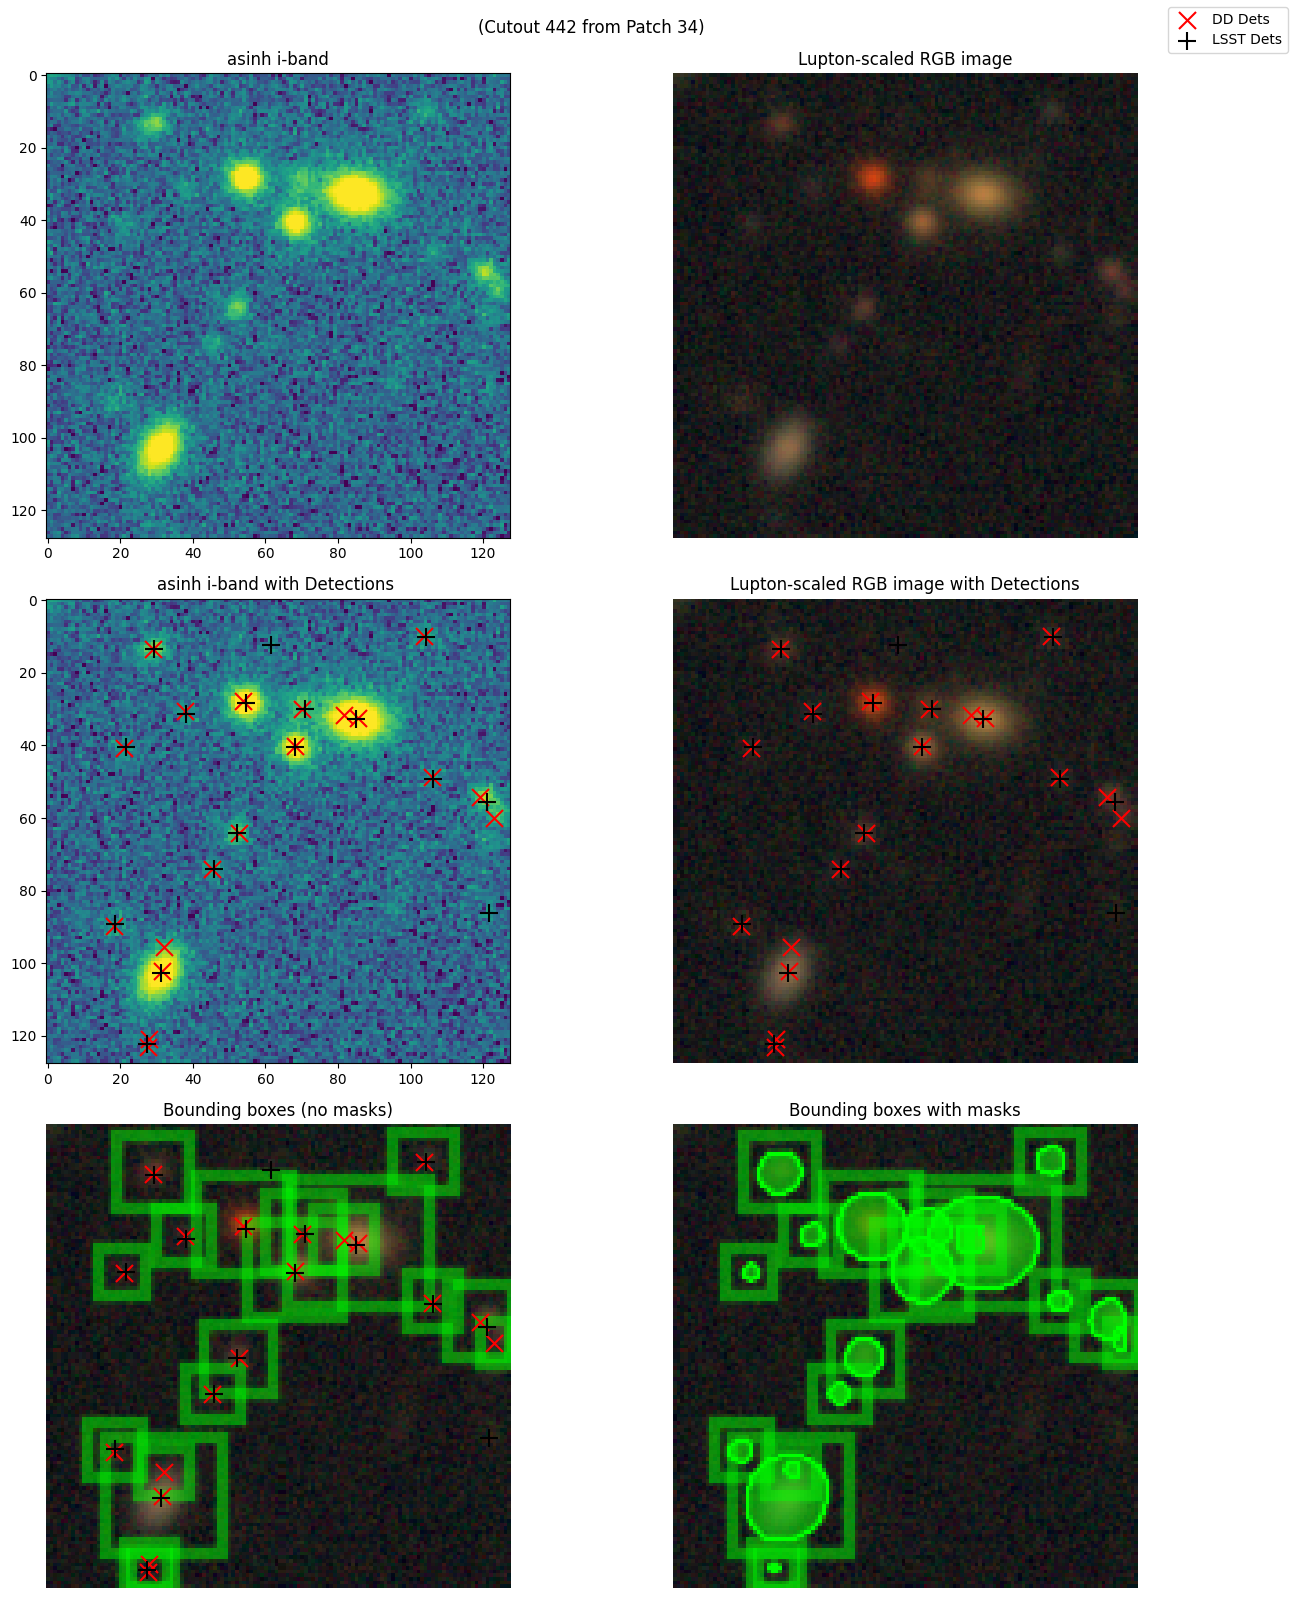

In [79]:
raw_image = sample['image_shaped']  # (H, W, 6) numpy array, asinh-scaled
r = raw_image[:, :, 3] # i-band
g = raw_image[:, :, 2] # r-band
b = raw_image[:, :, 1] # g-band
pmin = np.percentile([r, g, b], 1)
pmax = np.percentile([r, g, b], 99.5)
stretch = pmax - pmin # ~27.160368

# irg bands with make_lupton_rgb for better visualization
vis_img = make_lupton_rgb(r, g, b, minimum=pmin, stretch=stretch, Q=8)
dd_viz_scale = 1.0

# Visualizer instances
v_dd = Visualizer(
    vis_img.copy(),
    metadata=astrotest_metadata,
    scale=dd_viz_scale,
    enable_color_jitter=False,
    instance_mode=ColorMode.SEGMENTATION,
)
v_dd_nm = Visualizer(
    vis_img.copy(),
    metadata=astrotest_metadata,
    scale=dd_viz_scale,
    enable_color_jitter=False,
    instance_mode=ColorMode.SEGMENTATION
)
v_dd_boxes_only = Visualizer(
    vis_img.copy(),
    metadata=astrotest_metadata,
    scale=dd_viz_scale,
    enable_color_jitter=False,
    instance_mode=ColorMode.SEGMENTATION
)

# Render all visualization modes
dd_with_masks = v_dd.draw_instance_predictions(instances, lf=False, alpha=0.5, boxf=True)
dd_no_masks = v_dd_nm.draw_instance_predictions(instances, lf=False, alpha=0.5, boxf=True, draw_masks=False)
dd_boxes_only = v_dd_boxes_only.draw_instance_predictions(instances, lf=False, alpha=0.5, boxf=False, draw_masks=False)

fig, axes = plt.subplots(3, 2, figsize=(14, 16))

axes[0, 0].imshow(r, norm=asinh_norm(r, a=0.1), cmap='viridis')
axes[0, 0].set_aspect('equal')
axes[0, 0].set_title(f'asinh i-band', fontsize=12)

# Top-right: no boxes, no masks (just the lupton RGB with detection centers)
axes[0, 1].imshow(vis_img)
axes[0, 1].set_aspect('equal')
axes[0, 1].set_title('Lupton-scaled RGB image', fontsize=12)
axes[0, 1].axis('off')

axes[1, 0].imshow(r, norm=asinh_norm(r, a=0.1), cmap='viridis')
axes[1, 0].scatter(centers[:, 0] * dd_viz_scale, centers[:, 1] * dd_viz_scale, marker='x', s=150, c=['red'], label='DD Dets')
axes[1, 0].scatter(cutout_xpix * dd_viz_scale, cutout_ypix * dd_viz_scale, marker='+', s=150, c=['black'], label='LSST Dets')
axes[1, 0].set_aspect('equal')
axes[1, 0].set_title(f'asinh i-band with Detections ', fontsize=12)

# Top-right: no boxes, no masks (just the lupton RGB with detection centers)
axes[1, 1].imshow(vis_img)
axes[1, 1].set_aspect('equal')
axes[1, 1].set_title('Lupton-scaled RGB image with Detections', fontsize=12)
axes[1, 1].scatter(centers[:, 0] * dd_viz_scale, centers[:, 1] * dd_viz_scale, marker='x', s=150, c=['red'], label='DD Dets')
axes[1, 1].scatter(cutout_xpix * dd_viz_scale, cutout_ypix * dd_viz_scale, marker='+', s=150, c=['black'], label='LSST Dets')
axes[1, 1].axis('off')

# Bottom-left: boxes, no masks
axes[2, 0].imshow(dd_no_masks.get_image())
axes[2, 0].set_aspect('equal')
axes[2, 0].set_title('Bounding boxes (no masks)', fontsize=12)
axes[2, 0].scatter(centers[:, 0] * dd_viz_scale, centers[:, 1] * dd_viz_scale, marker='x', s=150, c=['red'], label='DD Dets')
axes[2, 0].scatter(cutout_xpix * dd_viz_scale, cutout_ypix * dd_viz_scale, marker='+', s=150, c=['black'], label='LSST Dets')
axes[2, 0].axis('off')

# Bottom-right: boxes with masks
axes[2, 1].imshow(dd_with_masks.get_image())
axes[2, 1].set_aspect('equal')
axes[2, 1].set_title('Bounding boxes with masks', fontsize=12)
# axes[2, 1].scatter(centers[:, 0] * dd_viz_scale, centers[:, 1] * dd_viz_scale, marker='x', s=150, c=['red'], label='DD Dets')
# axes[2, 1].scatter(cutout_xpix * dd_viz_scale, cutout_ypix * dd_viz_scale, marker='+', s=150, c=['black'], label='LSST Dets')
axes[2, 1].axis('off')
# shared legeend
handles, labels = axes[1, 0].get_legend_handles_labels()
fig.legend(handles, labels, frameon=True)

fig.suptitle(f"(Cutout {single_entry['cutout_id']} from Patch {single_entry['patch']})", y=0.99)
plt.tight_layout()

# Run Inference on All Test Data

The inference loop:
1. Iterates over batches from the test DataLoader.
2. Extracts `file_name` and `wcs` from each sample in the batch (these are not consumed by the model, but we need them for the output catalog).
3. Runs `model(batch)` in `torch.no_grad()` context (no gradients needed for inference, saves memory).
4. The model returns a list of dicts, one per image, each containing an `Instances` object with fields: `pred_boxes`, `scores`, `pred_classes`, `pred_masks`.
5. Collects all results and timing statistics.

In the multi-GPU script, results are gathered from all GPUs using `comm.gather()` and merged on the main process. Here we just accumulate directly.

In [ ]:
pred_dicts = []
file_names = []
wcs_info = []
total_compute_time = 0.0
total_num_dets = 0
total = len(test_loader)

print(f"Starting inference over {total} batches...")
start_time = time.perf_counter()

with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        batch_start = time.perf_counter()
        batch_size = len(batch)

        # Synchronize GPU before timing
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        # Extract metadata before model consumes the batch
        file_names.extend([d['file_name'] for d in batch])
        wcs_info.extend([d['wcs'] for d in batch])

        # Forward pass — model returns list of {"instances": Instances} dicts
        outputs = model(batch)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        infer_time = time.perf_counter() - batch_start
        total_compute_time += infer_time
        pred_dicts.extend(outputs)

        total_dets = sum(len(result['instances']) for result in outputs)
        total_num_dets += total_dets

        # Progress logging every 25%
        log_interval = max(total // 4, 1)
        if (idx + 1) % log_interval == 0 or (idx + 1) == total:
            elapsed = time.perf_counter() - start_time
            eta = (elapsed / (idx + 1)) * (total - idx - 1)
            print(
                f"Batch {idx+1}/{total} ({(idx+1)/total*100:.0f}%) | "
                f"Dets: {total_dets} | "
                f"Time: {infer_time*1000/batch_size:.1f}ms/img | "
                f"ETA: {eta:.1f}s"
            )

total_time = time.perf_counter() - start_time
total_images = len(file_names)
print(f"\nInference complete!")
print(f"  Total images: {total_images}")
print(f"  Total detections: {total_num_dets}")
print(f"  Total time: {total_time:.2f}s")
print(f"  Throughput: {total_images/total_time:.1f} imgs/sec")

# Build & Save the Detection Catalog

For each image's predictions, we:
1. Get predicted box centers in pixel coordinates using `pred_boxes.get_centers()`.
2. Convert pixel centers to RA/Dec using the cutout's WCS.
3. Encode predicted binary masks to **Run-Length Encoding (RLE)** format via `pycocotools.mask.encode()` — this is a compact representation that's standard in COCO-format results.
4. Collect all fields into a detection catalog dict and save as JSON.

The output JSON has fields: `id`, `ra`, `dec`, `class` (0=galaxy, 1=star), `file_name`, `bbox`, `score`, `rle_masks`.

In [ ]:
det_ras = []
det_decs = []
det_filenames = []
det_boxes = []
det_scores = []
det_classes = []
det_rle_masks = []

for raw_output, wcs_str, fn in zip(pred_dicts, wcs_info, file_names):
    instances = raw_output['instances'].to('cpu')
    # Convert predicted box centers from pixel to sky coordinates (RA/Dec)
    centers_pred = instances.pred_boxes.get_centers().numpy()
    det_coords = WCS(wcs_str).pixel_to_world(centers_pred[:, 0], centers_pred[:, 1])
    det_ras.extend(det_coords.ra.degree)
    det_decs.extend(det_coords.dec.degree)
    
    pred_boxes = instances.pred_boxes.tensor.numpy()
    pred_scores = instances.scores.numpy()
    pred_classes = instances.pred_classes.numpy()
    pred_masks = instances.pred_masks.numpy()
    
    # Encode each mask to RLE (Run-Length Encoding)
    rle_masks = []
    for mask in pred_masks:
        rle = mask_util.encode(np.asfortranarray(mask.astype(np.uint8)))
        rle['counts'] = rle['counts'].decode('utf-8')  # make JSON-serializable
        rle_masks.append(rle)
    
    num_instances = len(instances)
    det_filenames.extend(itertools.repeat(fn, num_instances))
    det_boxes.extend(pred_boxes.tolist())
    det_scores.extend(pred_scores.tolist())
    det_classes.extend(pred_classes.tolist())
    det_rle_masks.extend(rle_masks)

# Build and save the detection catalog
dd_det_cat = {
    'id': np.arange(len(det_ras)).tolist(),
    'ra': det_ras,
    'dec': det_decs,
    'class': det_classes,       # 0 = galaxy, 1 = star
    'file_name': det_filenames,
    'bbox': det_boxes,          # [x1, y1, x2, y2] in pixels
    'score': det_scores,
    'rle_masks': det_rle_masks  # RLE-encoded binary masks
}

output_file = f'{output_dir}/pred_s{test_score_thresh}_n{nms_thresh}.json'
with open(output_file, 'w') as f:
    json.dump(dd_det_cat, f, indent=2)

print(f"Detection catalog saved to: {output_file}")
print(f"Total detections: {len(det_ras)}")
n_galaxies = sum(1 for c in det_classes if c == 0)
n_stars = sum(1 for c in det_classes if c == 1)
print(f"  Galaxies: {n_galaxies}")
print(f"  Stars: {n_stars}")

# Cleanup

Free GPU memory and run garbage collection.

In [ ]:
del pred_dicts
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
print("GPU memory cleared.")